In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import time

In [34]:
tf.reset_default_graph() # THIS IS NECESSARY BEFORE MAKING NEW SESSION TO STOP IT ERRORING!!
try:
    sess
except:
    pass
else:
    sess.close()
    del sess
sess = tf.InteractiveSession()

number_neurons = 100

# All times are in ms.
dt = 0.2

# Post synaptic potential
# psp = tf.constant(1/(tau_l - tau_s) * (np.exp(-t/tau_l) - np.exp(-t/tau_s)),dtype=tf.float32)
tau_s = 3
tau_l = 10
refract_period = 3
refract_steps = int(refract_period/dt)

# Conductance of soma
g_l = 0.1
g_d = 2

# Dendritic learning
eta = 0.1
tau_delta = 100

# Synaptic weights
mu = 0.5
w_mean = mu
w_std = 2*mu

# Sigmoidal fxn 
psi_max = 0.15
k = 0.5
beta = 5
vc = 1
sigmoidal = lambda x : psi_max / (1 + k * tf.exp(beta * (vc - x)))
# Ok, so for our learning rule, psi = sigmoid = pm/(1+k*exp(beta*(vc - x)))
# ignore pm
# d/dx ln(psi(x)) = psi'(x)/psi(x)  
# =  (beta*k*exp(beta*(vc - x)))/(1 + k*exp(beta*(vc - x)) 
# =  beta / (1 + 1/k * exp(-beta*(vc - x)) )  
grad_log_sigmoidal = lambda x : beta / (1 + 1/k * tf.exp(beta * (x - vc)))

# Define somatic current input
E_e = 4.667
E_i = -1/3
g_e_ref = 1.0
g_i_ref = 2.0

block_time = 22000
start_osc = 500
end_osc = 10000
t_c = np.arange(0,current_time+dt,dt)
g_e = np.piecewise(t_c,[np.logical_and(t_c >= start_osc, t_c < end_osc)],[lambda x : g_e_ref*(0.5*np.sin(2*np.pi * x/100)+0.5)**2,0])
g_i = np.piecewise(t_c,[np.logical_and(t_c >= start_osc, t_c < end_osc)],[g_i_ref,0])

g_e_full_time = g_e_ref*(0.5*np.sin(2*np.pi * t_c/100)+0.5)
Um_ref = (g_e_full_time * E_e + g_i_ref * E_i)/(g_e_full_time + g_i_ref + 1e-8)

ge_full = np.concatenate([np.tile(g_e[:,None],[1,20]),np.zeros((len(t_c),number_neurons-20))],axis=1)
gi_full = np.concatenate([np.tile(g_i[:,None],[1,20]),np.zeros((len(t_c),number_neurons-20))],axis=1)

g_e_t = tf.constant(ge_full,dtype=tf.float32)
g_i_t = tf.constant(gi_full,dtype=tf.float32)

init_weights = np.random.randint(1,size = (number_neurons,number_neurons)) * (w_std * np.random.randn(number_neurons,number_neurons) + w_mean)
# np.fill_diagonal(init_weights,0.0)

# Initialize variables
U = tf.get_variable('U', initializer=tf.constant(np.zeros((number_neurons,1)),dtype=tf.float32))
Vw = tf.get_variable('Vw', initializer=tf.constant(np.zeros((number_neurons,1)),dtype=tf.float32))
W = tf.get_variable('W', initializer=tf.constant(init_weights,dtype=tf.float32))
I_spike = tf.get_variable('I_spike',initializer=tf.constant(np.zeros((number_neurons,1)),dtype=tf.float32))
V_spike = tf.get_variable('V_spike',initializer=tf.constant(np.zeros((number_neurons,1)),dtype=tf.float32))
delta_W = tf.get_variable('delta_W', initializer=tf.constant(np.zeros((number_neurons,number_neurons)),dtype=tf.float32))
refract_timer = tf.get_variable('refract_timer',initializer=tf.constant(np.zeros((number_neurons,1)),dtype=tf.float32))

# We want to define a while loop to efficiently run our computation
def gen_body(meas_dict):
    def body(ctr):
        I_som = tf.expand_dims(g_e_t[ctr],axis=1) * (E_e - U) + tf.expand_dims(g_i_t[ctr],axis=1) * (E_i - U)
        
        # Check for spikes, must not be refracting.
        spikes_ = tf.logical_and(tf.greater(tf.random_poisson(dt*sigmoidal(U),[]), 0),tf.equal(refract_timer,0))
        refract_timer_ = tf.where(tf.equal(spikes_,True),
                                  tf.constant(np.ones((number_neurons,1))*refract_steps,dtype=tf.float32),
                                  tf.where(tf.equal(refract_timer, 0), tf.constant(np.zeros((number_neurons,1)),dtype=tf.float32),refract_timer-1))
        
        # Euler's method
        I_spike_ = I_spike * (1 - dt / tau_s) + tf.cast(spikes_, tf.float32)/ tau_s
        V_spike_ = V_spike * (1 - dt / tau_l) + (dt/tau_l) * I_spike
        U_ = (U + dt * (-g_l * U + g_d * (Vw - U) + I_som))
        
        Vw_ = tf.matmul(W, V_spike_)
        Vw_st_ = (g_d)/(g_l + g_d) * Vw_
        
        PI_ = tf.matmul(tf.where(tf.equal(refract_timer,0),(tf.cast(spikes_,tf.float32)/dt - sigmoidal(Vw_st_))* grad_log_sigmoidal(Vw_st_),tf.constant(np.zeros((number_neurons,1)),dtype=tf.float32)),tf.transpose(V_spike_))
        # Note divide spike in PI by dt to model as delta function
        
        delta_W_ = delta_W * (1-dt/tau_delta) + (dt/tau_delta) * PI_
        W_ = W + eta * dt * delta_W
#         W_ = tf.linalg.set_diag(W_,tf.constant(np.zeros((number_neurons,)),dtype=tf.float32))

        # Operation to update at each time step
        step = tf.group(
            U.assign(U_),
            V_spike.assign(V_spike_),
            I_spike.assign(I_spike_),
            Vw.assign(Vw_),
            W.assign(W_),
            delta_W.assign(delta_W_),
            refract_timer.assign(refract_timer_))

        with tf.control_dependencies([step]):
            updates = tf.group([store[ctr].assign(val) for val,store in meas_dict.items()])

            with tf.control_dependencies([updates]):
                return ctr + 1
    return body

In [35]:
# Set up run
time_duration = 12000 # ms
t = np.arange(0,time_duration / dt) * dt

# Variables to store
meas_vars = [U,Vw]
to_meas_dict = {key : tf.Variable(np.zeros([np.shape(t)[0]] + key.get_shape().as_list()),dtype=tf.float32) for key in meas_vars}

run_op = tf.while_loop(lambda ctr : ctr < np.shape(t)[0],gen_body(to_meas_dict),[tf.constant(0)])

# Run
tf.global_variables_initializer().run() # Reset all variables
st = time.time()
sess.run(run_op)
print('Run time {0}'.format(time.time() - st))

# Pull out the data
meas_dict = {key.name.split(':')[0] : np.squeeze(np.array(item.eval())) for key,item in to_meas_dict.items()}


Run time 14.304172039031982


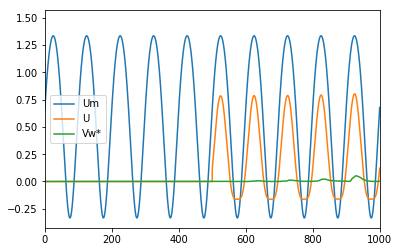

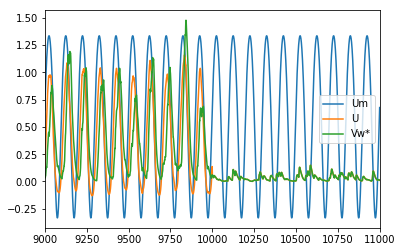

In [36]:
plt.plot(t_c,Um_ref,label='Um')
plt.plot(t,meas_dict['U'][:,0],label='U')
plt.plot(t,(g_d)/(g_l + g_d)*meas_dict['Vw'][:,0],label='Vw*')
plt.xlim([0,1000])
plt.legend()
plt.show()
plt.close()

plt.plot(t_c,Um_ref,label='Um')
plt.plot(t,meas_dict['U'][:,0],label='U')
plt.plot(t,(g_d)/(g_l + g_d)*meas_dict['Vw'][:,0],label='Vw*')
plt.xlim([9000,11000])
plt.legend()
plt.show()
plt.close()
    

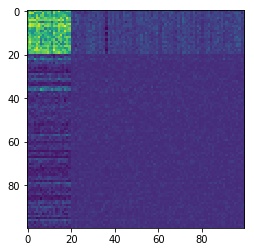

In [37]:
plt.imshow(W.eval())